# Gesture Recognition


### ``Problem Statement``
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can ``recognize five different gestures`` performed by the user which will help users control the TV without using a remote.

Gesture:
- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

### ``Outline of the Project.``
- Step 1. Importing Required Libraries.
- Step 2. Data Understanding & Data Visualization.
- Step 3. Data Preprocessing and create our own ``Generator``.
- Step 4. Model Building.
    - 4.1 Method_1 using Conv3D.
    - 4.2 Method_2 using Conv2D+LSTM.
    - 4.3 Method_2 using Conv2D+GRU.
    - 4.4 Method_3 using Transfer Learning MobileNetv2+GRU.
- Step 5. Model Evaluation.

#### Step_1: Importing Required Libraries.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import  random
from datetime import datetime
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from skimage.transform import resize

import cv2
import tensorflow as tf
import keras
from keras.utils import to_categorical
from collections import deque

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Input
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import optimizers

#### Step_2: Data Understanding & Data Visualization.

In [3]:
# Declare working directory 

root_dir = 'Project_data/'
train_img_path = os.path.join(root_dir, 'train/')
val_img_path = os.path.join(root_dir, 'val/')

In [4]:
# label/class list

label_ls = ['Thumbs Down', 'Thumbs Up','Left Swipe','Right Swipe','Stop Gesture']

In [7]:
# create a path for train/val csv file.
train_doc = np.random.permutation(open(f'{root_dir}train.csv').readlines())
val_doc = np.random.permutation(open(f'{root_dir}val.csv').readlines())

In [9]:
# get the img of each class
vid_ls = []
for label_ in label_ls:
    for vid_path in train_doc:
        match_str = f".*{label_}"
        match_ = re.match(match_str, vid_path.split(';')[0])
        if match_:
            vid_ls.append({'path':vid_path.split(';')[0], 'label': label_})
            break
        else:
            continue

**Data Visualization**

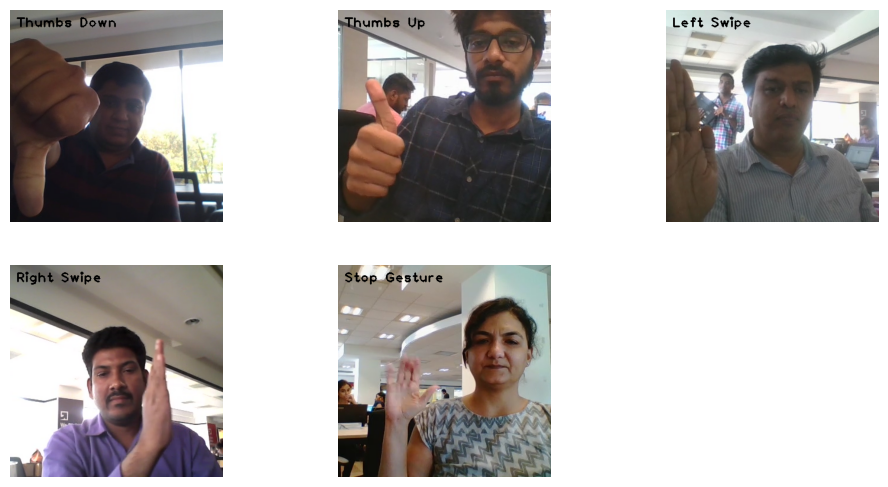

In [10]:
plt.figure(figsize=(12,16))
for cnt,img in enumerate(vid_ls):
    im = cv2.imread(os.path.join(train_img_path, img['path'],os.listdir(f'{train_img_path}{img["path"]}')[6]))
    imFrame = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    cv2.putText(imFrame, img['label'], (10,30), cv2.FONT_HERSHEY_PLAIN,1.5, (0,0,0),2)
   
    plt.subplot(5,3,cnt+1)
    plt.imshow(imFrame)
    plt.axis('off')

#### Step_3: Data Preprocessing and create our own ``Generator``

In [12]:
# Create a dataframe of path_to_img and respective lebel/class

train_csv_path = pd.read_csv(f'{root_dir}train.csv', header=None, delimiter=';')
val_csv_path = pd.read_csv(f'{root_dir}val.csv', header=None, delimiter=';')

**Generator**

In [14]:
# create our own generator 

def file_generator(csv_path,img_path, batch_size):
    """
    csv_path: csv_path for train/val data set
    img_path: get the path of image 
    batch_size: batch size for generator

    """
    shuffled = shuffle(csv_path, random_state=1)
    file_path_list = []

    for file,label in zip(shuffled[0], shuffled[2]):
            folder = [os.path.join(img_path, file, i) for i in os.listdir(os.path.join(img_path,file)) ]
            file_path_list.append([folder,[label]*len(folder)])
            
    st = 0
    end = batch_size
    batch_data = []
    for i in range(len(file_path_list)//batch_size+1):       
        batch_data.append(file_path_list[st:end])
        st = end
        end += batch_size
        if len(batch_data[i]) < batch_size :
            batch_data[i] = batch_data[i] + random.choices(file_path_list,k=batch_size-len(batch_data[i]))   
   
    return batch_data


def generator(csv_path,img_path, batch_size):
    batch_file = file_generator(csv_path,img_path, batch_size)

    iter = True    
    while iter:
        for batch in batch_file:
            try:
                img_arr = np.zeros((64,30,120,120,3))
                img_label = np.zeros((64,5))
                
                for batch_idx, dt in enumerate(batch):
                    for idx,(img_path, label_) in enumerate(zip(dt[0], dt[1])) :
                        im = cv2.imread(img_path)
                        im = resize(im, (120,120,3))
                        img_arr[batch_idx, idx, :,:,:] = im
                        img_label[batch_idx,:] =  to_categorical(label_, num_classes=5)
                yield (img_arr, img_label)
            except Exception as e:
                iter = False

In [15]:
# calculate steps per epochs to fit the model

batch_size = 64
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
# create an object of Train/val generator 
train_generator =  generator(train_csv_path, train_img_path, 64)
val_generator =  generator(val_csv_path, val_img_path, 64)

#### Step_4. Model Building.

**4.1 Method_1 using ``Conv3D.``**


In [19]:
if not os.path.exists('/kaggle/working/model_checkpoint'):
    os.makedirs('model_checkpoint')

dtime = str(datetime.now()).replace(' ','_').replace(':','_')[:-4]
# FILE = f"conv2d_lstm_{dtime}_.h5"
FILE = f"model_base_{dtime}_" + '{epoch:02d}_val_acc_{val_categorical_accuracy:.4f}.h5'
CHECKPOINT = ModelCheckpoint(filepath=f'/kaggle/working/model_checkpoint/{FILE}',monitor='val_categorical_accuracy', verbose=1, save_best_only=True,mode='max')
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=8, verbose=1)
# REDUCE_LR = LearningRateScheduler(lr_reduce)
REDUCE_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
callback_list = [CHECKPOINT,EARLY_STOP,REDUCE_LR ]

In [30]:
model_base = Sequential()

model_base.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(30,120,120,3), padding='same', activation='relu'))
model_base.add(Dropout(0.15))
model_base.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model_base.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model_base.add(Dropout(0.20))
model_base.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model_base.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model_base.add(Dropout(0.25))
model_base.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model_base.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model_base.add(Dropout(0.25))
model_base.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

#Flatten Layers
model_base.add(Flatten())

model_base.add(Dense(128, activation='relu'))
model_base.add(Dropout(0.5))

model_base.add(Dense(64, activation='relu'))
model_base.add(Dropout(0.5))

#softmax layer
model_base.add(Dense(5, activation='softmax'))

In [31]:
model_base.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 dropout_27 (Dropout)        (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 dropout_28 (Dropout)        (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 8, 30, 30, 32)    0         
 g3D)                                                 

In [32]:
model_base.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [33]:
base_model_hist = model_base.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0, callbacks=callback_list )

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.7651 - categorical_accuracy: 0.2159 
Epoch 1: val_categorical_accuracy improved from 0.24219 to 0.34375, saving model to /kaggle/working/model_checkpoint/model_base_2023-05-13_06_16_09.67_01_val_acc_0.3438.h5
11/11 [==============================] - 258s 26s/step - loss: 1.7651 - categorical_accuracy: 0.2159 - val_loss: 1.6071 - val_categorical_accuracy: 0.3438 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.6068 - categorical_accuracy: 0.1818 
Epoch 2: val_categorical_accuracy did not improve from 0.34375
11/11 [==============================] - 299s 30s/step - loss: 1.6068 - categorical_accuracy: 0.1818 - val_loss: 1.6018 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.5885 - categorical_accuracy: 0.2116 
Epoch 3: val_categorical_accuracy did not improve from 0.34375
11/11 [==============================] - 210s

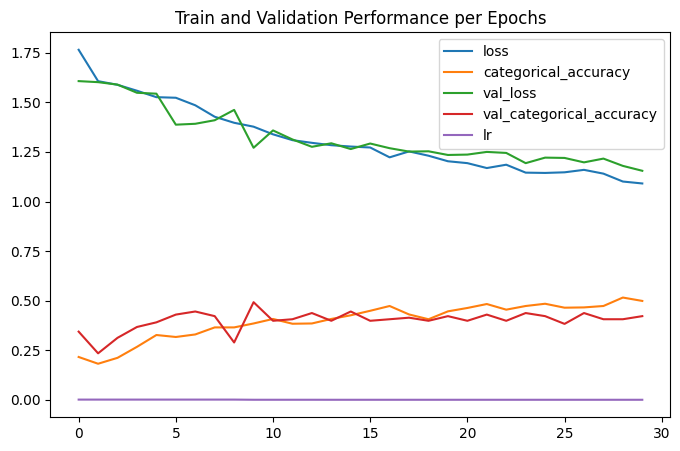

In [35]:
# plot_model_performance(hist_lstm_)
pd.DataFrame(base_model_hist.history).plot(figsize=(8,5))
plt.title("Train and Validation Performance per Epochs")
plt.show()

Max Validation Accuracy: ``49.219%``

**4.2 Method_2 using ``Conv2D+LSTM.``**


In [17]:
conv2d_lstm = Sequential()
conv2d_lstm.add(TimeDistributed( Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=(30, 120,120,3)))
conv2d_lstm.add(TimeDistributed(MaxPooling2D((4,4))))
conv2d_lstm.add(TimeDistributed(Dropout(0.15)))

conv2d_lstm.add(TimeDistributed( Conv2D(32, (3,3), padding='same', activation='relu')))
conv2d_lstm.add(TimeDistributed(MaxPooling2D((4,4))))
conv2d_lstm.add(TimeDistributed(Dropout(0.25)))

conv2d_lstm.add(TimeDistributed( Conv2D(64, (3,3), padding='same', activation='relu')))
conv2d_lstm.add(TimeDistributed(MaxPooling2D((3,3))))
conv2d_lstm.add(TimeDistributed(Dropout(0.25)))



conv2d_lstm.add(TimeDistributed(Flatten()))

conv2d_lstm.add(LSTM(64))
conv2d_lstm.add(Dense(5, activation='softmax'))

conv2d_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 30, 30, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 7, 7, 32)     0

In [38]:
if not os.path.exists('/kaggle/working/model_checkpoint'):
    os.makedirs('model_checkpoint')

dtime = str(datetime.now()).replace(' ','_').replace(':','_')[:-4]
# FILE = f"conv2d_lstm_{dtime}_.h5"
FILE = f"conv2d_lstm_{dtime}_" + '{epoch:02d}_val_acc_{val_categorical_accuracy:.4f}.h5'
CHECKPOINT = ModelCheckpoint(filepath=f'/kaggle/working/model_checkpoint/{FILE}',monitor='val_categorical_accuracy', verbose=1, save_best_only=True,mode='max')
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=8, verbose=1)
# REDUCE_LR = LearningRateScheduler(lr_reduce)
REDUCE_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
callback_list = [CHECKPOINT,EARLY_STOP,REDUCE_LR ]

In [40]:
conv2d_lstm.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# fit the model
conv2d_lstm_hist = conv2d_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,callbacks=callback_list )

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.6241 - categorical_accuracy: 0.1861 
Epoch 1: val_categorical_accuracy improved from -inf to 0.18750, saving model to /kaggle/working/model_checkpoint/conv2d_lstm_2023-05-13_08_45_20.24_01_val_acc_0.1875.h5
11/11 [==============================] - 233s 23s/step - loss: 1.6241 - categorical_accuracy: 0.1861 - val_loss: 1.5979 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.5887 - categorical_accuracy: 0.2500 
Epoch 2: val_categorical_accuracy improved from 0.18750 to 0.34375, saving model to /kaggle/working/model_checkpoint/conv2d_lstm_2023-05-13_08_45_20.24_02_val_acc_0.3438.h5
11/11 [==============================] - 283s 28s/step - loss: 1.5887 - categorical_accuracy: 0.2500 - val_loss: 1.5831 - val_categorical_accuracy: 0.3438 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.5358 - categorical_accuracy: 0.2969 


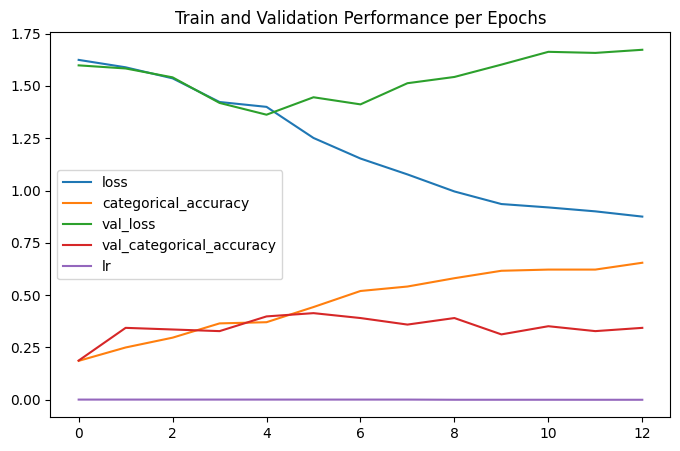

In [44]:
# plot_model_performance
pd.DataFrame(conv2d_lstm_hist.history).plot(figsize=(8,5))
plt.title("Train and Validation Performance per Epochs")
plt.show()

Max Validation Accuracy: ``41.406%``

**4.3 Method_3 using ``Conv2D+GRU.``**

In [14]:
conv2d_gru = Sequential()
conv2d_gru.add(TimeDistributed( Conv2D(32, (3,3), padding='same', activation='relu'), input_shape=(30, 120,120,3)))
conv2d_gru.add(TimeDistributed(MaxPooling2D((3,3))))
conv2d_gru.add(TimeDistributed(Dropout(0.15)))

conv2d_gru.add(TimeDistributed( Conv2D(64, (3,3), padding='same', activation='relu')))
conv2d_gru.add(TimeDistributed(MaxPooling2D((2,2))))
conv2d_gru.add(TimeDistributed(Dropout(0.15)))

conv2d_gru.add(TimeDistributed( Conv2D(128, (2,2), padding='same', activation='relu')))
conv2d_gru.add(TimeDistributed(MaxPooling2D((2,2))))
conv2d_gru.add(TimeDistributed(Dropout(0.20)))


conv2d_gru.add(TimeDistributed(Flatten()))

conv2d_gru.add(GRU(64))
conv2d_gru.add(Dense(32, activation='relu'))
conv2d_gru.add(Dropout(0.15))
conv2d_gru.add(Dense(5, activation='softmax'))

conv2d_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 40, 40, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 40, 40, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 40, 40, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 20, 20, 64)   0

In [16]:
conv2d_gru.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [17]:
if not os.path.exists('/kaggle/working/model_checkpoint'):
    os.makedirs('model_checkpoint')

dtime = str(datetime.now()).replace(' ','_').replace(':','_')[:-4]
# FILE = f"conv2d_lstm_{dtime}_.h5"
FILE = f"conv2d_gru_{dtime}_" + '{epoch:02d}_val_acc_{val_categorical_accuracy:.4f}.h5'
CHECKPOINT = ModelCheckpoint(filepath=f'/kaggle/working/model_checkpoint/{FILE}',monitor='val_categorical_accuracy', verbose=1, save_best_only=True,mode='max')
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=8, verbose=1)
# REDUCE_LR = LearningRateScheduler(lr_reduce)
REDUCE_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
callback_list = [CHECKPOINT,EARLY_STOP,REDUCE_LR ]

In [18]:
conv2d_gru_hist = conv2d_gru.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,callbacks=callback_list )

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.6930 - categorical_accuracy: 0.2401 
Epoch 1: val_categorical_accuracy improved from -inf to 0.17969, saving model to /kaggle/working/model_checkpoint/conv2d_gru_2023-05-13_10_46_20.10_01_val_acc_0.1797.h5
11/11 [==============================] - 318s 31s/step - loss: 1.6930 - categorical_accuracy: 0.2401 - val_loss: 1.5983 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.5773 - categorical_accuracy: 0.2543 
Epoch 2: val_categorical_accuracy improved from 0.17969 to 0.26562, saving model to /kaggle/working/model_checkpoint/conv2d_gru_2023-05-13_10_46_20.10_02_val_acc_0.2656.h5
11/11 [==============================] - 231s 23s/step - loss: 1.5773 - categorical_accuracy: 0.2543 - val_loss: 1.5652 - val_categorical_accuracy: 0.2656 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.4707 - categorical_accuracy: 0.3920 
Ep

Max Validation Accuracy: ``73.438%``


Let's load and rebuild this conv2d_gru model which has highest accuracy of 73%

In [22]:
# load the saved model.
conv2d_gru_v2 = tf.keras.models.load_model('./model_checkpoint/conv2d_gru_2023-05-13_10_46_20.10_17_val_acc_0.7344.h5')

In [23]:
# custom LR schedular
def lr_reduce(epoch,lr):
    if epoch < 7:
        return lr
    else:
        return lr*tf.math.exp(-0.01)
    
dtime = str(datetime.now()).replace(' ','_').replace(':','_')[:-4]
FILE = f"conv2d_gru_v2_{dtime}_" + '{epoch:02d}_val_acc_{val_categorical_accuracy:.4f}.h5'
CHECKPOINT = ModelCheckpoint(filepath=f'./model_checkpoint/{FILE}',monitor='val_categorical_accuracy', verbose=1, save_best_only=True,mode='max')
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# REDUCE_LR = LearningRateScheduler(lr_reduce)
callback_list = [CHECKPOINT,EARLY_STOP ]

In [25]:
conv2d_gru_v2.compile(optimizer=optimizers.Adam(learning_rate=9.8020e-04), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [26]:
conv2d_gru_v2_hist = conv2d_gru_v2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, 
                validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=24,callbacks=callback_list )

Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.5662 - categorical_accuracy: 0.7912 
Epoch 25: val_categorical_accuracy improved from -inf to 0.53906, saving model to ./model_checkpoint\conv2d_gru_v2_2023-05-13_21_31_56.29_25_val_acc_0.5391.h5
11/11 [==============================] - 292s 27s/step - loss: 0.5662 - categorical_accuracy: 0.7912 - val_loss: 1.2747 - val_categorical_accuracy: 0.5391
Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.3835 - categorical_accuracy: 0.8523 
Epoch 26: val_categorical_accuracy improved from 0.53906 to 0.71094, saving model to ./model_checkpoint\conv2d_gru_v2_2023-05-13_21_31_56.29_26_val_acc_0.7109.h5
11/11 [==============================] - 343s 33s/step - loss: 0.3835 - categorical_accuracy: 0.8523 - val_loss: 0.8721 - val_categorical_accuracy: 0.7109
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.2441 - categorical_accuracy: 0.9233 
Epoch 27: val_categorical_accuracy improved f

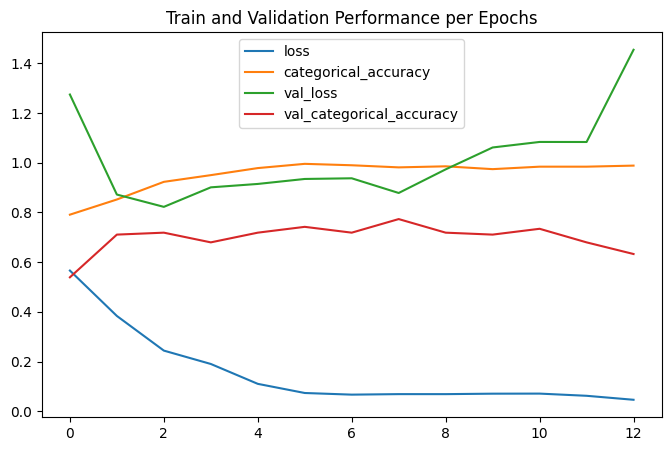

In [27]:
conv2d_gru_v2_hist
# plot_model_performance(hist_lstm_)
pd.DataFrame(conv2d_gru_v2_hist.history).plot(figsize=(8,5))
plt.title("Train and Validation Performance per Epochs")
plt.show()

Max Validation Accuracy: ``77.344%``


**4.4 Method_4 using Transfer Learning ``MobileNetV2+GRU.``**

In [18]:
# importing mobilenetv2 
from keras.applications import MobileNetV2

In [19]:
# create base layer of CNN with mobileNetV2
mbNet = MobileNetV2(
    input_shape=(120,120,3),
    weights="imagenet",
    include_top=False
)

In [20]:
# set the trainable parameter to True for last block of base layer.
for layer in mbNet.layers:

    if re.match('block_16_*',layer.name):
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
# Let's check the trainable/ non-trainable layer
for layer in mbNet.layers:
    print(layer.name, layer.trainable)

input_1 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [22]:
# Build an architecture 
mb_net_gru = Sequential()

mb_net_gru.add(TimeDistributed(mbNet, input_shape=(30,120,120,3)) )

mb_net_gru.add(TimeDistributed(Flatten()))

mb_net_gru.add(GRU(64))
mb_net_gru.add(Dense(32, activation='relu'))
mb_net_gru.add(Dropout(0.15))
mb_net_gru.add(Dense(5, activation='softmax'))

mb_net_gru.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 30, 4, 4, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 20480)        0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 64)                3944832   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                

In [61]:
mb_net_gru.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [2]:
  
dtime = str(datetime.now()).replace(' ','_').replace(':','_')[:-4]
FILE = f"mobNetV2_gru_v2_{dtime}_" + '{epoch:02d}_val_acc_{val_categorical_accuracy:.4f}.h5'
CHECKPOINT = ModelCheckpoint(filepath=f'./model_checkpoint/{FILE}',monitor='val_categorical_accuracy', verbose=1, save_best_only=True,mode='max')
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# REDUCE_LR = LearningRateScheduler(lr_reduce)
callback_list = [CHECKPOINT,EARLY_STOP ]

In [63]:
mb_net_gru_hist = mb_net_gru.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,callbacks=callback_list )

Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 0.8161 - categorical_accuracy: 0.7315 
Epoch 1: val_categorical_accuracy did not improve from 0.77344
11/11 [==============================] - 412s 39s/step - loss: 0.8161 - categorical_accuracy: 0.7315 - val_loss: 1.1968 - val_categorical_accuracy: 0.5781
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 0.4702 - categorical_accuracy: 0.8935 
Epoch 2: val_categorical_accuracy did not improve from 0.77344
11/11 [==============================] - 407s 38s/step - loss: 0.4702 - categorical_accuracy: 0.8935 - val_loss: 1.0353 - val_categorical_accuracy: 0.6328
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.2348 - categorical_accuracy: 0.9531 
Epoch 3: val_categorical_accuracy did not improve from 0.77344
11/11 [==============================] - 397s 37s/step - loss: 0.2348 - categorical_accuracy: 0.9531 - val_loss: 1.0726 - val_categorical_accuracy: 0.5469
Epoch 4/25
11/11 [=======

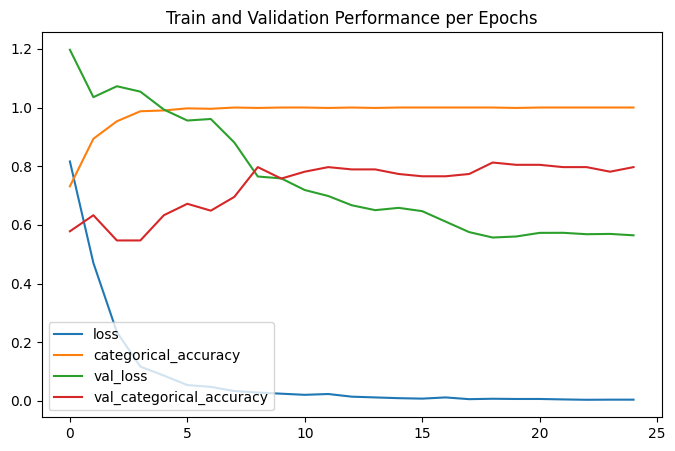

In [64]:
# plot_model_performance(hist_lstm_)
pd.DataFrame(mb_net_gru_hist.history).plot(figsize=(8,5))
plt.title("Train and Validation Performance per Epochs")
plt.show()

Max Validation Accuracy: ``81.25%``

#### Step_5: Model Evaluation.

As we have tried multiple different architecture/model, out of those models ``MobileNetV2+GRU`` gave us best possible result in terms of accuracy around ``81%``. which is based on the concept of ``Transfer Learning``.

We will go ahead and choose that model for further prediction.